## Running SPAdes

**Why do we expect short reads to produce a more fragmented assembly than long reads?**

We expect short reads to produce a more fragmented assembly than long reads because the shorter reads result in different ways of conceivably joining the reads together. With longer reads, we do not have this problem, as there is a far smaller degree of ambiguity in assembly.

**Why does a single-molecule sequencing like PacBio have a higher error rate than Illumina?**

Single-molecule sequencing like PacBio has a higher error rate than Illumina since the signal-to-noise ratio from singlular DNA molecules is fairly low compared to Illumina sequencing. Moreover, Illumina sequencing has a redundancy factor in that the clustering step generates approximately 1000 copies for a DNA insert. However, PacBio only has a single DNA polymerase and so the error rate is higher.

The command line input below starts a new `tmux` session from which we will run `SPAdes`.

`tmux new -s spades`

The command line input below runs `SPAdes` and outputs to the Lab 8 directory the result of taking the short Illumina reads from `/data/Lab8_data/illumina_reads_R1.fastq`, `/data/Lab8_data/illumina_reads_R2.fastq`, and the long PacBio read `/data/Lab8_data/pacbio_reads.fastq`. The result is an assembled genome.

`-o .` indicates the output should be in the current directory. `-1` indicates the first short paired-end Illumina read, and likewise for `-2`. `--pacbio` tells `spades` that we are passing in long PacBio reads. `-t 1` is used to ensure that only a single core is used.

`spades.py -o . -1 /data/Lab8_data/illumina_reads_R1.fastq -2 /data/Lab8_data/illumina_reads_R2.fastq --pacbio /data/Lab8_data/pacbio_reads.fastq -t 1`

It turns out that my assembly failed. I had the following error message.

`=== Error correction and assembling warnings:`

` * 0:17:33.613   564M / 1G    WARN    General                 (kmer_coverage_model.cpp   : 218)   Too many erroneous kmers, the estimates might be unreliable`

`======= Warnings saved to /data/home/5450915/Lab 8/warnings.log`


`=== ERRORs:`

` * 0:01:07.536     4M / 1G    ERROR   General                 (mmapped_reader.hpp        : 113)   mmap(2) failed. Reason: Cannot allocate memory. Error code: 12`

` * system call for: "['/data/home/softwares/SPAdes-3.13.1-Linux/bin/spades-core', '/data/home/5450915/Lab 8/K99/configs/config.info']" finished abnormally, err code: 255`

I tried running `spades.py -o -t 1 --restart-from last`, yet I had another error, detailed below.

`== Error ==  system call for: "['/bigdata/home/softwares/SPAdes-3.13.1-Linux/bin
/spades-hammer', '/data/home/5450915/Lab 8/corrected/configs/config.info']" finished abnormally, err code: 255`

I suspect that my assembly failed because the system was unable to allocate enough memory to the process and so it crashed during execution. Instead, I use the given data in `/data/lab9_data/` for the remainder of this lab.

## Generate assembly statistics

The command below runs `assembly-stats` on the provided `contigs.fasta` and `scaffolds.fasta` files.

`assembly-stats /data/Lab9_data/contigs.fasta /data/Lab9_data/scaffolds.fasta`

The total length of contigs was 6680581bp and the total length of scaffolds was 6680345bp. The number of contigs was 180 and the number of scaffolds was 176. The N50 was 234690bp.

*Why is N50 is useful statistic to calculate?*

The N50 is a useful statistic to calculate because it functions as a weighted median. That is, we desire a statistic that places a greater emphasis on a longer contigs, as opposed to smaller contigs. 

*Why not just list the mean or median contig length?*

The mean or median contig length does not tell us as much information about how well the assembly worked. The mean and median are more sensitive to changes in the distribution of the length of contigs, and they have no bias towards the longer contigs that we desire.

*In your assembly, are scaffolds longer than contigs, or are scaffolds approximately equal to contigs?*

The mean scaffold length is 37956.51bp and the mean contig length is 37114.34bp. In the assembly, scaffolds are slightly longer than contigs.

### Extra Credit



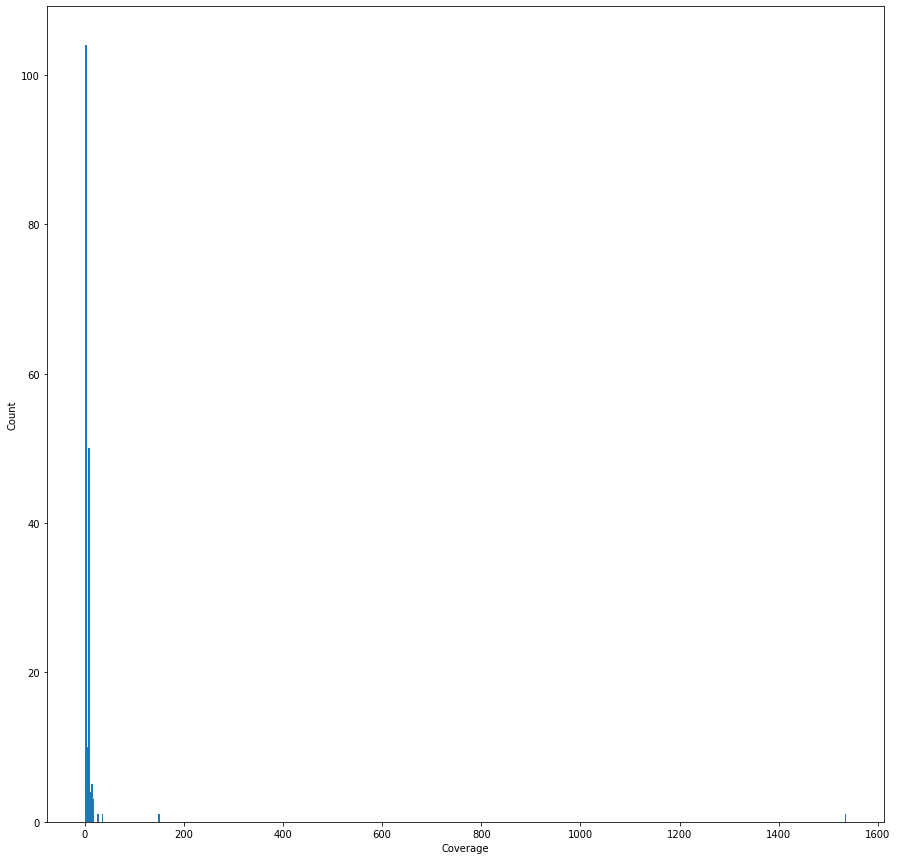

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

contigs = open("contigs.fasta", "r")
coverage = []
for line in contigs:
    if '>' in line:
        coverage.append(float(line.split("cov_")[1].rstrip()))
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlabel('Coverage')
plt.ylabel('Count')
plt.show(plt.hist(coverage, bins=500))

The outliers of coverage are such that it makes the plot too large to be useful. We can reduce the range to get a better look at the distribution in general.

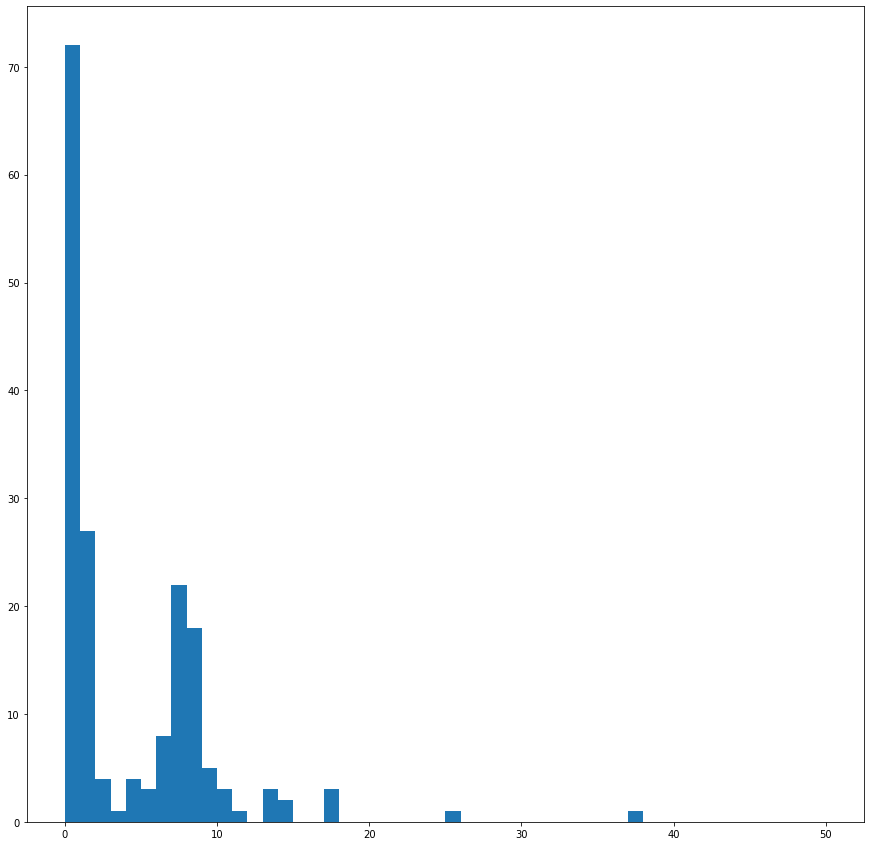

There are outliers at coverages 150.0 and 1536.0.
The mean coverage is 13.724810777777778.


In [52]:
plt.show(plt.hist(coverage, bins=50, range=[0, 50]))
coverage.sort()
print("There are outliers at coverages {} and {}.".format(coverage[-2], coverage[-1]))
print("The mean coverage is {}.".format(sum(coverage)/len(coverage)))

The distribution is not uniform, nor is it Gaussian. The distribution is approximately bimodal, with a peak at 1, and a secondary peak at 8. Of course, we have not considered the presence of outliers. I wasn't sure about the intuition for explaining the presence of contigs with coverage an integer multiple of the mean coverage.

## Identify the taxon from which your genome originated

We begin by running running `rna_hmm3.py` on the assembled contigs to locate rRNA genes. The `-i` option gives the input `/data/Lab9_data/contigs.fasta`, `-o` writes the output to `contigs.rna.gff`, and -L gives the path to the HMM database `/data/Lab9_data/HMM3`.
Credit given for `rna_hmm3.py` below.

>Ying Huang, Weizhong Li, Patricia W. Finn and David L. Perkins.
Ribosomal RNA identification in metagenomic and metatranscriptomic datasets. 
Submitted as a bookchapter

`rna_hmm3.py -i /data/Lab9_data/contigs.fasta -o contigs.rna.gff -L /data/Lab9_data/HMM3`

Afterwards, I deleted the lines from `contigs.rna.gff` that did not include 16S rRNA genes. 

Next, I ran the following command to extract nucleic acid sequences of the 16S rRNA genes from the assembly. The input FASTA file `/data/Lab9_data/contigs.fasta` is specified with `-fi`, the input GFF file `contigs.rna.gff` is specified with `-bed`, and the output is piped to `contigs.rna.fasta`.


`bedtools getfasta -fi /data/Lab9_data/contigs.fasta -bed contigs.rna.gff` > `contigs.rna.fasta`

I then uploaded the output to the SeqMatch tool. The genus-level classification was Pseudomonas. I came to this conclusion by exaimining the result of the query. The tool found a high match for all the 16S sequences in terms of the SeqMatch score S_ab, which is the number of unique 7-base oligomers shared between the sequence and a given RDP sequence divided by the lowest number of unique oligos in either sequence. In particular, the algorithm suggested a strong correlation with the Pseudomonas frederiksbergensis bacterium, as each of the gene sequences had a SeqMatch score of 1 with the bacterium.

## Genome annotation

I uplaoded `/data/Lab9_data/contigs.fasta` to the genome annotation services RAST and BASys. The RAST job was successful, and I was able to use the result for the research and write-up. Unfortunately, I was unable to obtain a genome annotation using BASys. According to Chenling, this was fine. Therefore, I proceeded with the genome annotation from RAST.

Below are screenshots from RAST. I submitted the job well in advance, yet it did not complete. Moreover, when I tried to use a different server, I received a proxy error.

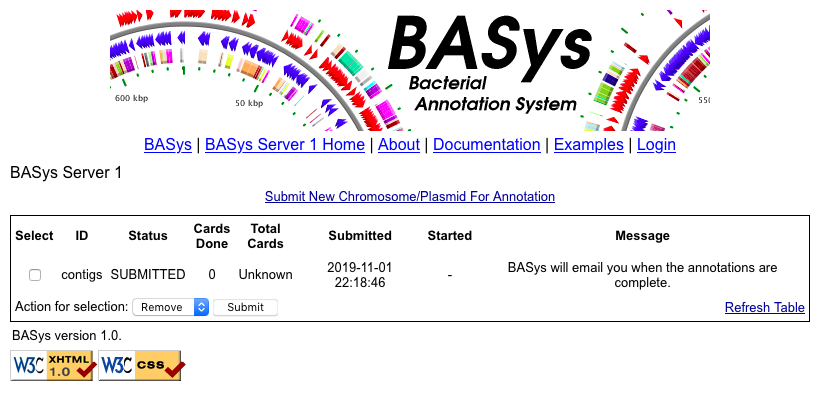

<center>The above screenshot was taken 2019-11-03.</center>

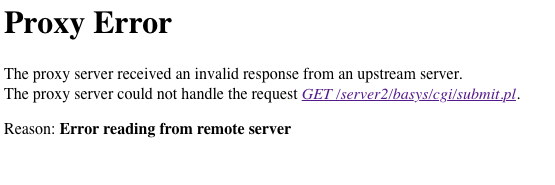

<center>The above screenshot was taken 2019-11-04.</center>

## Research and write-up

I used the SEED Viewer provided by RAST to analyze the bacterium genome. From a high level, it was revealed that the nearly all of the various subsystems were all represented to some extent, with the exception of "Photosynthesis" and "Cell Division and Cell Cycle", which had a subsystem feature count of 0. This was not unexpected, since we are examining an organism from the Pseudomonas genus. Therefore, this is not a plant genome, and we would not expect to see any pathways or other subsystems relating to photosynthesis. With regard to cell division and cell cycle subsystems, I found that this bacterium's phylogenetic neighbors differed. For example, Pseudomonas fluorescens PfO-1 has 26 related functional roles for the bacterial cytoskeleton. However, the Pseudomonas frederiksbergensis (which we assume this genome was derived from) had no information on the bacterial cytoskeleton or other subsystems such as macromolecular synthesis operons, indicating a lack of function in these areas (or errors in assembling the genome).

Unsurprisingly, the bacterium's closest phylogenetic neighbors are also of the Pseudomonas genus. Specifically, they are Pseudomonas fluorescens PfO-1 (score of 547) and Pseudomonas aeruginosa PAO1 (score of 518). It can be inferred that they, like Pseudomonas frederiksbergensis, are decomposers of organic compounds in water and in soil. (Zheng et al., 2019)

During my research, I found a paper by Chatterjee et al., 2017 that discusses the improved salt tolerance of soil in the presence of Pseudomonas frederiksbergensis OS261. Salt tolerance is highly beneficial for red pepper plant growth. Specifically, the researchers found that the bacterium exhibits stress mitigating properties, manifesting in plant growth promotion through decreasing emissions of ethylene and regulating antioxidant enzymes. To verify this, I examined the genome annotation under the "Amino Acids and Derivatives" category and"Lysine, threonine, methionine, and cysteine" subcategory, to find the "Methionine Biosynthesis" subsystem, where I finally found the role of S-adenosylmethionine synthetase (EC 2.5.1.6). The paper suggests a strong correlation between 1-aminocyclopropane-1-carboxylate (ACC) deaminase and salinity resistance. Indeed, above I learned the genome encodes S-adenosylmethionine (SAM) synthetase, which is involved in a biosynthetic pathway for ACC deaminase. The researchers also noted that ACC deaminase in certain microbes is linked with higher levels of the Chloramphenicol acetyltransferase (CAT) enzyme, and therefore higher salt tolerance by eliminating reactive oxygen species (ROS). Although the organism here is likely a different isolate from the one in the paper, it implies that this bacterium may provide a similar function under the same conditions. For future analysis, it may helpful to obtain the genome of Pseudomonas frederiksbergensis OS261 and an annotation for it. This would perhaps allow us examine the roles across genomes much more effectively.

Additionally, earlier in 2019, Zheng et al. published their findings on the capacity of Pseudomonas frederiksbergensis Strain 11-D3 in mobilizing and solubizing phosphorus. In particular, the researchers found that two gene clusters (pqqEDCBA and pqqFECBA) - both implicated in pyrroloquinoline quinone (PQQ) biosynthesis - were found in the genome, which were both shown before to be related to its capacity to solubilize inorganic phosphate. Also, the pqq operon acts as a key regulation factor for expression of 2-keto-D-gluconic acid and gluconic acid. In the Pseudomonas genome and with respect to high-efficiency inorganic P solubilization, both compounds are essential. In terms of my genome annotation, I found that there are a number of roles relating to 2-keto-D-gluconic acid (also known as 2-ketogluconate). Epimerase KguE, 2-ketogluconate transporter, 2-ketogluconate utilization repressor PtxS
2-ketogluconate kinase, 2-ketogluconate 6-phosphate reductase, are all under the "2-Ketogluconate Utilization" subsystem ("Monosaccharides" subcategory and "Carbohydrates" category). This would imply that 2-keto-d-gluconic acid is express to some level and can therefore be involved with mobilizing inorganic phosphorus. Even though this paper examines a particular strain of Pseudomonas frederiksbergensis for its efficiency in solubilizing phosphorus, there is some evidence that our bacterium may have similar properties due to the presence of various roles relating to 2-keto-D-gluconic acid. Gluconic acid may also be expressed, depending on a potential deoxidation reaction of 2-keto-D-gluconic acid of the hydroxy group at position 2.

To summarize the findings, there is a case for our organism being helpful for plant growth overall, and so it may be of use for agriculture. The SAM synthetase pathway can indirectly enable higher salinity resistance in harsh soil conditions, and 2-keto-D-gluconic acid (along with gluconic acid) can facilitate mobilization and solubilization of inorganic phosphorus for better plant nutrition.

> Chatterjee P, Samaddar S, Anandham R, et al. Beneficial Soil Bacterium Pseudomonas frederiksbergensis OS261 Augments Salt Tolerance and Promotes Red Pepper Plant Growth. Front Plant Sci. 2017;8:705. Published 2017 May 4. doi:10.3389/fpls.2017.00705

>Zheng BX, Zhang HK, Zhang YS, Ding K. The Draft Genome Sequence of Pseudomonas frederiksbergensis Strain 11-D3 Reveals Its Ability To Mobilize Phosphorus. Microbiol Resour Announc. 2019;8(11):e01321-18. Published 2019 Mar 14. doi:10.1128/MRA.01321-18

